In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My Drive

/content/drive/My Drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
from tensorflow.keras import backend as K
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [59]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

features = train_img/255.0
labels = train_digit.to_numpy()

X_test = test_img/255.0

from sklearn.model_selection import train_test_split

validation_split = 0.1

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 100)

In [60]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 3,
        height_shift_range = 3,
        zoom_range=0.2,
        )

flow1=train_datagen.flow(X_train,y_train,batch_size=16,seed=2020) 
test_datagen = ImageDataGenerator()
flow2=test_datagen.flow(X_val,y_val,batch_size=16,seed=2020) 



In [33]:
len(y_train)

1638

In [9]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [61]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))

    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.BatchNormalization()(img_input)
    conv_1 = layers.Activation('mish')(conv_1)
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',)(conv_1) 
    
    conv_2_1 = layers.BatchNormalization()(conv_1)
    conv_2_1 = layers.Activation('mish')(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    conv_2_1 = layers.Dropout(rate = 0.3)(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('mish')(add_2_1)
    
    conv_2_2 = layers.BatchNormalization()(out_2_1)
    conv_2_2 = layers.Activation('mish')(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    conv_2_2 = layers.Dropout(rate = 0.3)(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('mish')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)

    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('mish')(add_3_1)
    
    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.BatchNormalization()(conv_4_0)
    conv_4_1 = layers.Activation('mish')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('mish')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)

    conv_5_0 = layers.Conv2D(512, kernel_size = 1, strides = 1)(pool_4)
    
    conv_5_1 = layers.BatchNormalization()(conv_5_0)
    conv_5_1 = layers.Activation('mish')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same',activation = 'mish')(conv_5_1)
    
    # ShortCut connection
    add_5_1 = layers.add([conv_5_0, conv_5_1])
    out_5_1 = layers.Activation('mish')(add_5_1)
    
    # FC layers
    img_features = layers.Flatten()(out_5_1)
    img_features = layers.BatchNormalization()(img_features)
    img_features = layers.Dense(1024, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(512, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(256, activation = 'mish')(img_features)
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(img_features)
    
    model = tf.keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model


def train_model_v1(model, train, test , epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 3, min_lr = 3e-5)
    
    history = model.fit(train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = test, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train,  epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 3, min_lr = 3e-5)
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_split = validation_split, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [62]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0003)
    model_list.append(model)

In [ ]:
model_list[0].summary()

Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_380 (BatchN (None, 28, 28, 1)    4           input_51[0][0]                   
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 28, 28, 1)    0           batch_normalization_380[0][0]    
__________________________________________________________________________________________________
conv2d_740 (Conv2D)             (None, 28, 28, 128)  1280        activation_610[0][0]             
_____________________________________________________________________________________

***************Trainig_my_model_0*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.3972 - accuracy: 0.2192 - val_loss: 3.0801 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0876 - accuracy: 0.2892 - val_loss: 4.1954 - val_accuracy: 0.1171
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9024 - accuracy: 0.3554 - val_loss: 3.4092 - val_accuracy: 0.1317
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.7811 - accuracy: 0.3679 - val_loss: 3.9395 - val_accuracy: 0.1171
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.6368 - accuracy: 0.4379 - val_loss: 2.0718 - val_accuracy: 0.3805
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5401 - accuracy: 0.4617 - val_loss: 1.5559 - val_accuracy: 0.4780
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 1.4372 - 

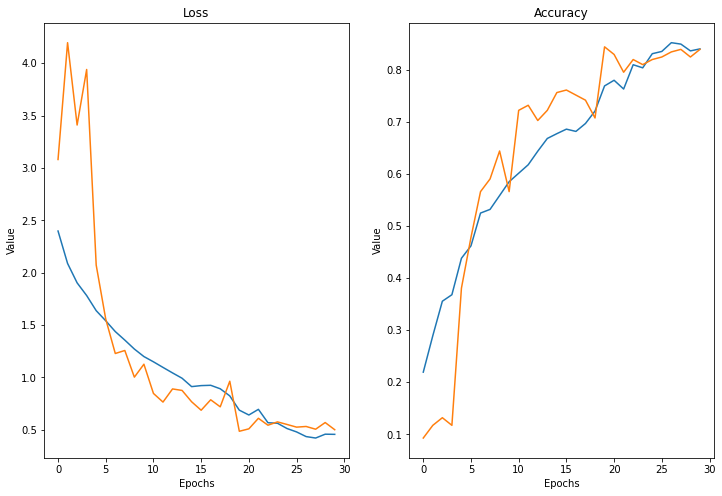

***************Trainig_my_model_1*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.3611 - accuracy: 0.2203 - val_loss: 2.7961 - val_accuracy: 0.0976
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0387 - accuracy: 0.2946 - val_loss: 4.5636 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9090 - accuracy: 0.3456 - val_loss: 4.6976 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7636 - accuracy: 0.3950 - val_loss: 4.0965 - val_accuracy: 0.1366
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7372 - accuracy: 0.3901 - val_loss: 2.3669 - val_accuracy: 0.2390
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5485 - accuracy: 0.4612 - val_loss: 1.9784 - val_accuracy: 0.3512
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 1.4750 - 

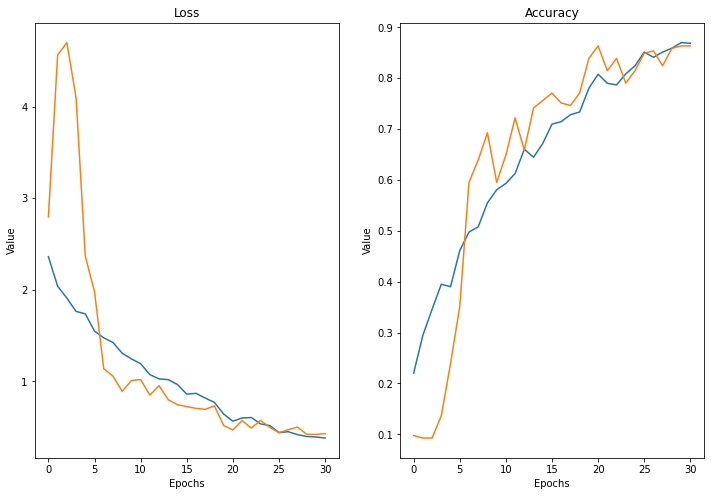

***************Trainig_my_model_2*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.4607 - accuracy: 0.2235 - val_loss: 3.0968 - val_accuracy: 0.0878
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0820 - accuracy: 0.2751 - val_loss: 3.9756 - val_accuracy: 0.1024
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9574 - accuracy: 0.3055 - val_loss: 2.9652 - val_accuracy: 0.1171
Epoch 4/200
116/116 [==============================] - 1s 12ms/step - loss: 1.8214 - accuracy: 0.3695 - val_loss: 3.1737 - val_accuracy: 0.1024
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7566 - accuracy: 0.3733 - val_loss: 1.5725 - val_accuracy: 0.4244
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 1.6365 - accuracy: 0.4270 - val_loss: 1.6386 - val_accuracy: 0.4634
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5217 - 

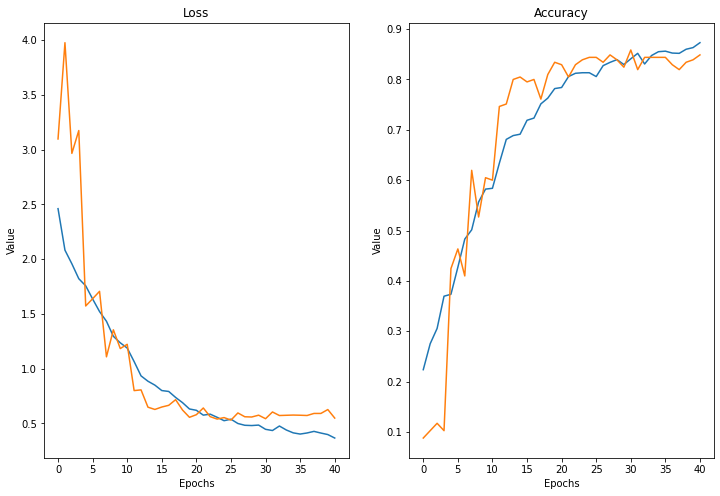

***************Trainig_my_model_3*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.3994 - accuracy: 0.2360 - val_loss: 3.6722 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0699 - accuracy: 0.2691 - val_loss: 3.5595 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 1s 12ms/step - loss: 1.9227 - accuracy: 0.3348 - val_loss: 5.6848 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.8218 - accuracy: 0.3663 - val_loss: 3.1664 - val_accuracy: 0.1512
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 1.7026 - accuracy: 0.3890 - val_loss: 1.8353 - val_accuracy: 0.3756
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 1.5981 - accuracy: 0.4433 - val_loss: 1.1675 - val_accuracy: 0.5951
Epoch 7/200
116/116 [==============================] - 1s 12ms/step - loss: 1.5004 - 

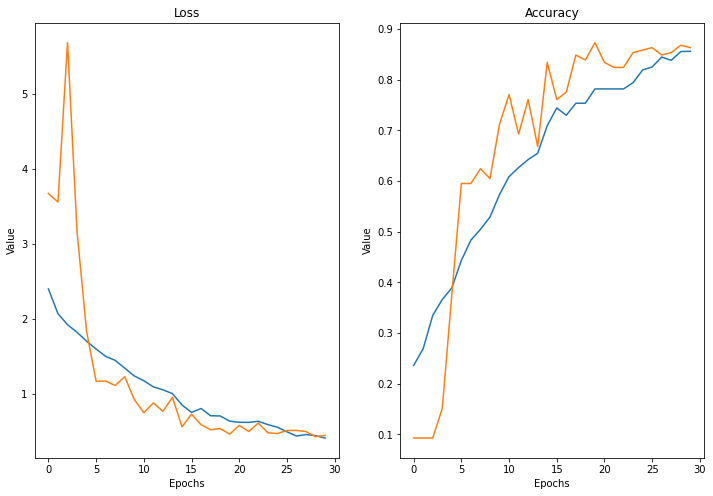

***************Trainig_my_model_4*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.4253 - accuracy: 0.2349 - val_loss: 3.0633 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0430 - accuracy: 0.2979 - val_loss: 3.5045 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 12ms/step - loss: 1.9124 - accuracy: 0.3315 - val_loss: 4.8828 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7742 - accuracy: 0.3831 - val_loss: 3.6693 - val_accuracy: 0.1171
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.6567 - accuracy: 0.4276 - val_loss: 2.2661 - val_accuracy: 0.2878
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5583 - accuracy: 0.4628 - val_loss: 1.2630 - val_accuracy: 0.5659
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 1.4388 - 

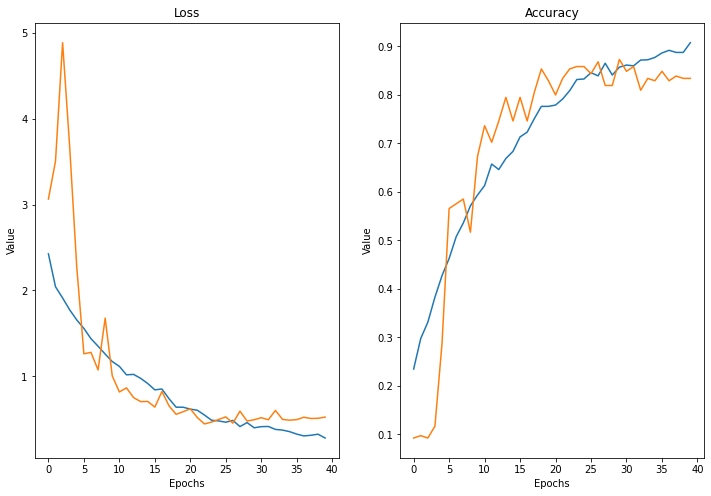

***************Trainig_my_model_5*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.4040 - accuracy: 0.2284 - val_loss: 3.5302 - val_accuracy: 0.0927
Epoch 2/200
116/116 [==============================] - 2s 13ms/step - loss: 2.0560 - accuracy: 0.3006 - val_loss: 3.9412 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9666 - accuracy: 0.3190 - val_loss: 4.9084 - val_accuracy: 0.0829
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.8580 - accuracy: 0.3516 - val_loss: 2.8070 - val_accuracy: 0.1366
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 1.7611 - accuracy: 0.3874 - val_loss: 2.0137 - val_accuracy: 0.3024
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 1.6130 - accuracy: 0.4411 - val_loss: 1.5813 - val_accuracy: 0.4878
Epoch 7/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5727 - 

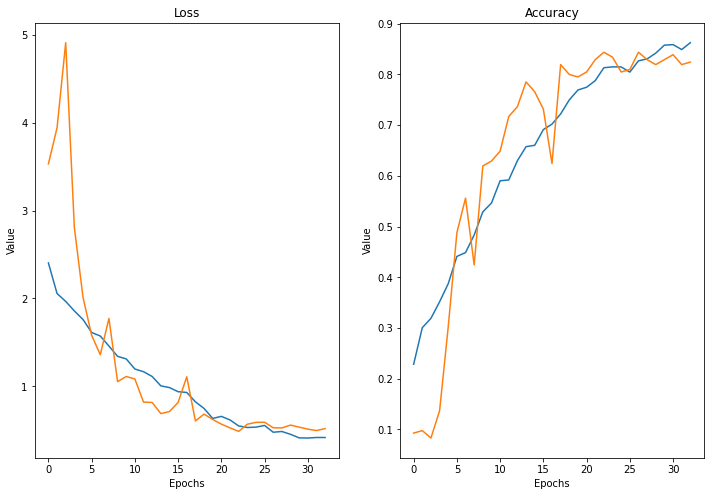

***************Trainig_my_model_6*****************
Epoch 1/200
116/116 [==============================] - 2s 15ms/step - loss: 2.4050 - accuracy: 0.2089 - val_loss: 3.6163 - val_accuracy: 0.0976
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0201 - accuracy: 0.3017 - val_loss: 5.2208 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9268 - accuracy: 0.3283 - val_loss: 4.0407 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.8149 - accuracy: 0.3782 - val_loss: 3.0697 - val_accuracy: 0.1561
Epoch 5/200
116/116 [==============================] - 1s 13ms/step - loss: 1.7153 - accuracy: 0.3950 - val_loss: 1.8853 - val_accuracy: 0.3561
Epoch 6/200
116/116 [==============================] - 1s 13ms/step - loss: 1.5818 - accuracy: 0.4514 - val_loss: 1.9143 - val_accuracy: 0.3317
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 1.4934 - 

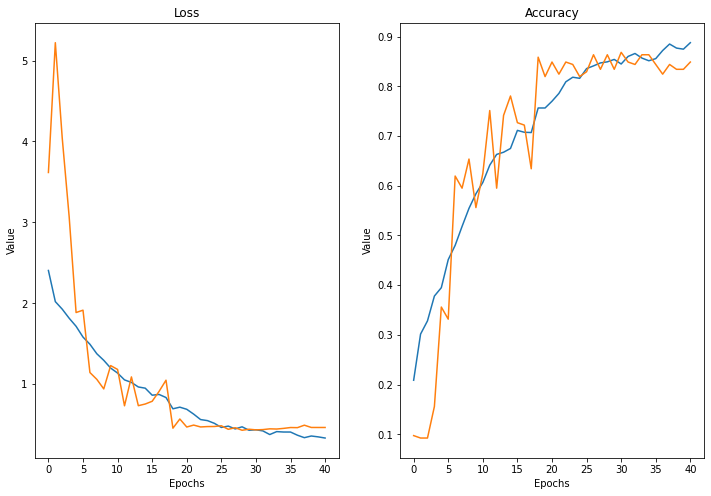

***************Trainig_my_model_7*****************
Epoch 1/200
116/116 [==============================] - 2s 16ms/step - loss: 2.4227 - accuracy: 0.1980 - val_loss: 2.5382 - val_accuracy: 0.0878
Epoch 2/200
116/116 [==============================] - 2s 13ms/step - loss: 2.0418 - accuracy: 0.2914 - val_loss: 2.7822 - val_accuracy: 0.0976
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9489 - accuracy: 0.3114 - val_loss: 5.2185 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 13ms/step - loss: 1.8221 - accuracy: 0.3576 - val_loss: 3.0150 - val_accuracy: 0.1854
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 1.7022 - accuracy: 0.4026 - val_loss: 2.3287 - val_accuracy: 0.2488
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 1.6294 - accuracy: 0.4173 - val_loss: 1.2273 - val_accuracy: 0.5707
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 1.5596 - 

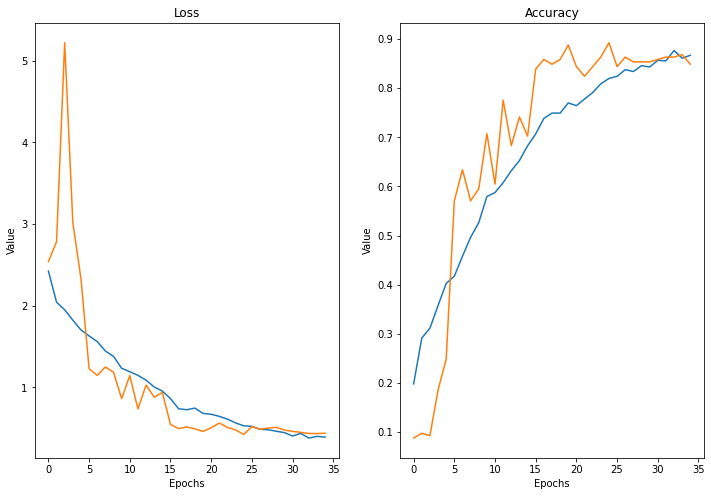

***************Trainig_my_model_8*****************
Epoch 1/200
116/116 [==============================] - 2s 16ms/step - loss: 2.3965 - accuracy: 0.2192 - val_loss: 3.0998 - val_accuracy: 0.1024
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9998 - accuracy: 0.3104 - val_loss: 4.5768 - val_accuracy: 0.0927
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.8830 - accuracy: 0.3521 - val_loss: 4.1235 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 1s 13ms/step - loss: 1.8208 - accuracy: 0.3543 - val_loss: 4.8208 - val_accuracy: 0.0927
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 1.6296 - accuracy: 0.4308 - val_loss: 2.3580 - val_accuracy: 0.1415
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 1.5308 - accuracy: 0.4628 - val_loss: 1.9495 - val_accuracy: 0.3512
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 1.3861 - 

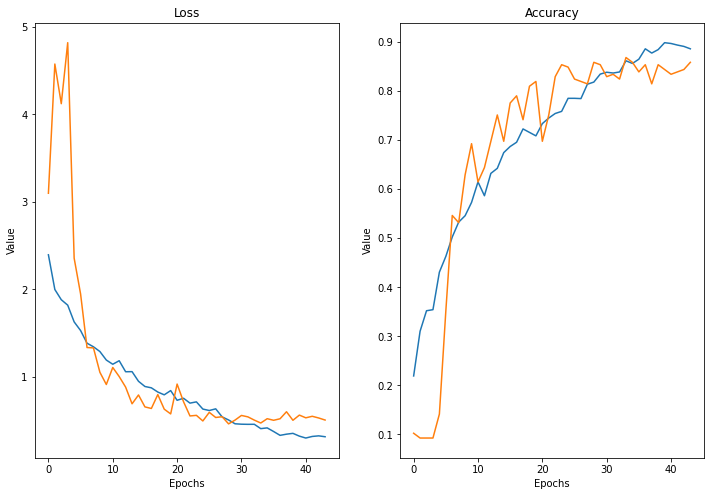

***************Trainig_my_model_9*****************
Epoch 1/200
116/116 [==============================] - 2s 16ms/step - loss: 2.4285 - accuracy: 0.2122 - val_loss: 2.7170 - val_accuracy: 0.0732
Epoch 2/200
116/116 [==============================] - 1s 13ms/step - loss: 2.0570 - accuracy: 0.2914 - val_loss: 4.4927 - val_accuracy: 0.1024
Epoch 3/200
116/116 [==============================] - 1s 13ms/step - loss: 1.9207 - accuracy: 0.3277 - val_loss: 7.1190 - val_accuracy: 0.0927
Epoch 4/200
116/116 [==============================] - 2s 13ms/step - loss: 1.8293 - accuracy: 0.3679 - val_loss: 3.3251 - val_accuracy: 0.1171
Epoch 5/200
116/116 [==============================] - 2s 13ms/step - loss: 1.6838 - accuracy: 0.4205 - val_loss: 1.5839 - val_accuracy: 0.4390
Epoch 6/200
116/116 [==============================] - 2s 13ms/step - loss: 1.6375 - accuracy: 0.4286 - val_loss: 1.3239 - val_accuracy: 0.5610
Epoch 7/200
116/116 [==============================] - 2s 13ms/step - loss: 1.4479 - 

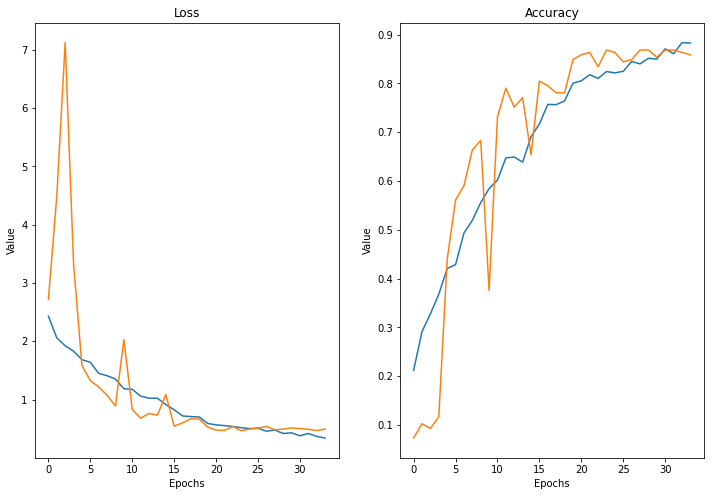

In [63]:
epochs = 200
batch_size = 16
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], flow1, flow2, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [64]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(flow2)
    result_list.append(result)

************************Evaluating_my_model_0************************
13/13 [==============================] - 0s 4ms/step - loss: 0.4853 - accuracy: 0.8439
************************Evaluating_my_model_1************************
13/13 [==============================] - 0s 5ms/step - loss: 0.4684 - accuracy: 0.8634
************************Evaluating_my_model_2************************
13/13 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.8585
************************Evaluating_my_model_3************************
13/13 [==============================] - 0s 4ms/step - loss: 0.4625 - accuracy: 0.8732
************************Evaluating_my_model_4************************
13/13 [==============================] - 0s 4ms/step - loss: 0.4960 - accuracy: 0.8732
************************Evaluating_my_model_5************************
13/13 [==============================] - 0s 4ms/step - loss: 0.4886 - accuracy: 0.8439
************************Evaluating_my_model_6*************

In [65]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(X_test)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [66]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [67]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,3,5,5,9,8,5,8,5,5,5
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,9,4,8,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,1,6,9,1,3,1,8,8,6,6,6


In [68]:
submission = pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,5
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,6


In [70]:
for i in range(len(model_list)):
  tf.keras.models.save_model(model_list[i],'ckpt1/model{}'.format(i))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ckpt1/model0/assets
INFO:tensorflow:Assets written to: ckpt1/model1/assets
INFO:tensorflow:Assets written to: ckpt1/model2/assets
INFO:tensorflow:Assets written to: ckpt1/model3/assets
INFO:tensorflow:Assets written to: ckpt1/model4/assets
INFO:tensorflow:Assets written to: ckpt1/model5/assets
INFO:tensorflow:Assets written to: ckpt1/model6/assets
INFO:tensorflow:Assets written to: ckpt1/model7/assets
INFO:tensorflow:Assets written to: ckpt1/model8/assets
INFO:tensorflow:Assets written to: ckpt1/model9/assets


In [73]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('ckpt1/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(flow2, epochs = 5, batch_size = 1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Epoch 1/5
13/13 [==============================] - 0s 16ms/step - loss: 0.5763 - accuracy: 0.8000
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.4571 - accuracy: 0.8390
Epoch 3/5
13/13 [==============================] - 0s 11ms/step - loss: 0.3160 - accuracy: 0.8878
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.2539 - accuracy: 0.8927
Epoch 5/5
13/13 [==============================] - 0s 11ms/step - loss: 0.2754 - accuracy: 0.9073
************************Loading_my_model_1************************
************************Re-training_my_model_1************************
Epoch 1/5
13/13 [==============================] - 0s 12ms/step - loss: 0.6161 - accuracy: 0.7951
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.4278 - accuracy: 0.8683
Epoch 3/5
13/13 [=====================

In [74]:
re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(X_test)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [75]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [76]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,0,5,5,8,8,5,8,5,5,5
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,9,4,4,9,9,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,6,6,1,1,6,3,6,8,6,6,6


In [77]:
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("baseline1.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,5
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,6


# 추가한 것

- data augmentation 
  - 성능은 잘 모르겠으나 overfitting문제가 꽤 해결됨.
  - 사이트에서 나온 점수는 test의 1%로 매긴 점수라 알 수 없지만 기존 결과로는 아마 overfitting이 심했을 것 같음.

## 생각해야 할 것

- 알파벳에서 숫자를 더 확실하게 분류할 방법! 전처리 과정이 중요할 것 같다.
- learning rate 외의 parameter tuning 이나 기존 모델 결과와의 ensemble